Note that I write this notebook by learning topics and source codes from various resources, but the main book that I have read is "Python for Machine Learning" by S. Raschka and V. Mirjalili, which is my favorite. Therefore, most of the codes here will have the same structure as their book. I also would like to thank both authors for writing this easy-understanding book, which I think is the good one for beginners.

# Principal Component Analysis

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [3]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
x = df_wine.copy()
y = x.pop(0)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 0)

In [7]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)

## Construct a Covariance Matrix 

In [8]:
x_train.shape

(124, 13)

We have 13 features, so our covariance matrix will have the size of 13x13, and we'll have 13 pairs of eigenvectors and eigenvalues.

In [9]:
cov_mat = np.cov(x_train_std.T) 
#Transpose the matrix first to calculate covariance for each pair of features, not each pair of observations!

In [10]:
eig_val, eig_vec = np.linalg.eig(cov_mat)
print('Eigenvalues \n%s' % eig_val)

Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


## A Variance-Explained Ratio Plot 

In [11]:
tot = sum(eig_val)
var_exp = [ev/tot for ev in sorted(eig_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [12]:
import matplotlib.pyplot as plt

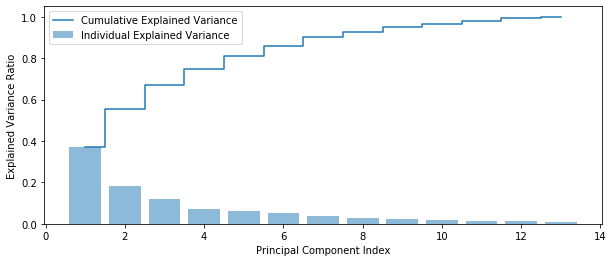

In [13]:
plt.figure(figsize = (10,4))
plt.bar(range(1,14), var_exp, alpha = 0.5, align='center', label = 'Individual Explained Variance')
plt.step(range(1,14), cum_var_exp, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc = 'best')
plt.show()

## Feature Transformation 

In [14]:
#Sort the eigenpairs
eigenpairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]
eigenpairs.sort(key = lambda k: k[0], reverse=True)

I'll choose only 2 principal components of which variance explains about 60% of the total variance (you can see it in the graph above). Furthermore, it is easy to visually show it via graph since now we are dealing with 2-dimension data.

In [15]:
w = np.hstack((eigenpairs[0][1][:, np.newaxis], eigenpairs[1][1][:, np.newaxis]))
print('The Projection Matrix W:\n', w)

The Projection Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


Now I will transform a sample x onto a PCA subspace.

In [16]:
#The example of transformation for the first row
x_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [17]:
#Let's do it for all rows
x_train_pca = x_train_std.dot(w)

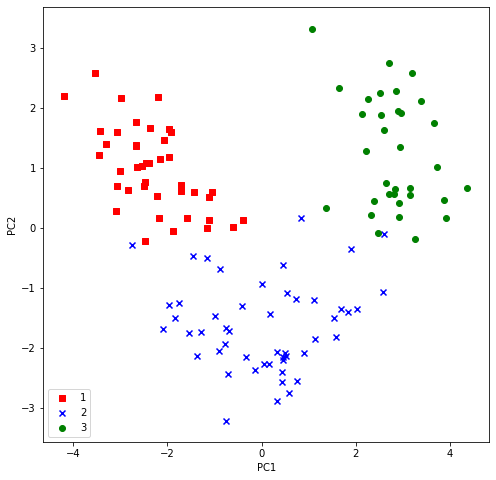

In [18]:
#Let's visualize it
plt.figure(figsize = (8,8))
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(x_train_pca[y_train == l,0], x_train_pca[y_train == l,1], c = c, label = l, marker = m)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.show()

# PCA via Scikit-Learn with the Wine Data

In [19]:
from matplotlib.colors import ListedColormap

In [20]:
def plot_regions(x, y, classifier, resolution = 0.02):
    #Setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #Plot the decision surface
    x1_min, x1_max = x[:,0].min() - 1, x[:,0].max() + 1
    x2_min, x2_max = x[:,1].min() - 1, x[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha = 0.4, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x= x[y == cl, 0], y = x[y == cl, 1], alpha=0.6, c = cmap(idx), edgecolor = 'black',
                   marker = markers[idx], label = cl)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


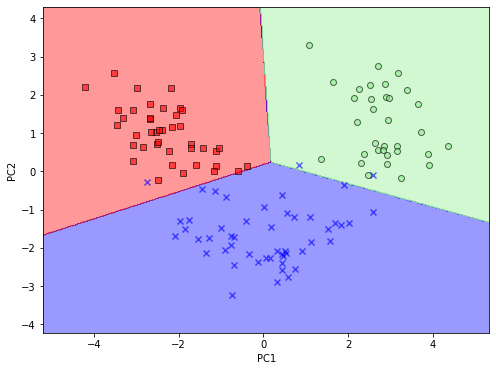

In [22]:
pca = PCA(n_components = 2)
lr = LogisticRegression()
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)
lr.fit(x_train_pca, y_train)
plt.figure(figsize = (8,6))
plot_regions(x_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

If we are interested in the all principal component axes, we can set n_components = None, then all components are kept.

In [23]:
pca_all = PCA(n_components=None)
x_train_pca_all = pca_all.fit_transform(x_train_std)
pca_all.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# Linear Discriminant Analysis

The Linear Discriminant Analysis (LDA) is the algorithm used to reduce the number of dimensions in a dataset. The difference of LDA from PCA is that LDA is the supervised learning algorithm, which considers the target variable in the calculation (while PCA is the unsupervised learning, which does not).

## Compute Mean Vectors

In [24]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in np.unique(y_train):
    mean_vecs.append(np.mean(x_train_std[y_train == label], axis = 0))
    print('Mean Vector %s: %s\n' % (label, mean_vecs[label - 1]))

Mean Vector 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

Mean Vector 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

Mean Vector 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



## Compute the within-Class Scatter Matrix

In [25]:
n = x_train.shape[1] #Number of features
S_w = np.zeros((n,n))
for label, mean_vec in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.zeros((n,n))
    for row in x_train_std[y_train == label]:
        row, mean_vec = row.reshape(n,1), mean_vec.reshape(n,1)
        class_scatter += (row - mean_vec).dot((row - mean_vec).T)
    S_w += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_w.shape[0], S_w.shape[1]))

Within-class scatter matrix: 13x13


The assumption that we are making when we are computing the scatter matrices is that the class labels in the training set are uniformly distributed. However, if we print the number of class labels, we see that this assumption is violated:

In [26]:
print('Class Label Distribution: %s' % np.bincount(y_train)[1:])

Class Label Distribution: [41 50 33]


So we need to scale the individual scatter matrix (S_i) before sum them up to S_w.

In [27]:
n = x_train.shape[1] #Number of features
S_w = np.zeros((n,n))
for label, mean_vec in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(x_train_std[y_train == label].T)
    S_w += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_w.shape[0], S_w.shape[1]))

Within-class scatter matrix: 13x13


## Compute the between-Class Scatter Matrix

In [28]:
mean_overall = np.mean(x_train_std, axis = 0)
#Use n from above
S_B = np.zeros((n,n))
for i, mean_vec in enumerate(mean_vecs):
    m = x_train[y_train == i+1].shape[0]
    mean_vec = mean_vec.reshape(n,1)
    mean_overall = mean_overall.reshape(n,1)
    S_B += m * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between class scatter matrix: 13x13


## Eigens

In [29]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_B))

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key = lambda k: k[0], reverse = True)
print('Eigenvalues in descending order:\n')
for value in eig_pairs:
    print(value[0])

Eigenvalues in descending order:

349.617808905994
172.7615221897939
5.043759076173278e-14
2.842170943040401e-14
1.8150338203069463e-14
1.8150338203069463e-14
1.3115100786370513e-14
1.3115100786370513e-14
1.2855980804265828e-14
1.2855980804265828e-14
1.0667616719177046e-14
1.0667616719177046e-14
3.761531009849436e-15


## Discriminality

Discriminality is the measurement of how much of the class-discriminatory information is captured by the linear discriminants (eigenvectors). We can visually inspect it by plotting the linear discriminants like what we did with the explained variance plot in PCA.

In [30]:
import matplotlib.pyplot as plt

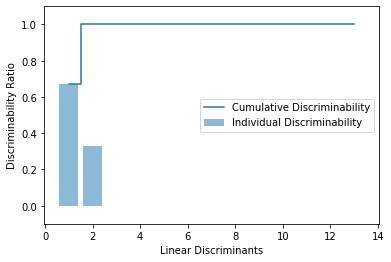

In [31]:
tot = sum(eig_vals.real)
discr = [(i/tot) for i in sorted(eig_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14), discr, alpha = 0.5, align = 'center', label = 'Individual Discriminability')
plt.step(range(1,14), cum_discr, where = 'mid', label = 'Cumulative Discriminability')
plt.xlabel('Linear Discriminants')
plt.ylabel('Discriminability Ratio')
plt.ylim([-0.1,1.1])
plt.legend(loc = 'best')
plt.show()

In [32]:
# Next we will stack the two most discriminative eigenvectors to create the transformation matrix W.
w = np.hstack((eig_pairs[0][1][:, np.newaxis].real, eig_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## Projecting Samples onto the New Feature Space

In [33]:
x_train_lda = x_train_std.dot(w)

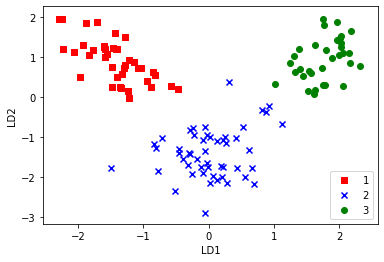

In [34]:
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(x_train_lda[y_train == l, 0], x_train_lda[y_train == l, 1] * -1, c=c, label = l, marker = m)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc = 'lower right')
plt.show()

# LDA using Scikit-Learn

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

In [36]:
lda = LDA(n_components=2)
x_train_lda = lda.fit_transform(x_train_std, y_train)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


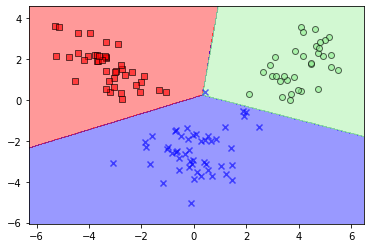

In [37]:
lr = LogisticRegression()
lr = lr.fit(x_train_lda, y_train)

plot_regions(x_train_lda, y_train, classifier=lr)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


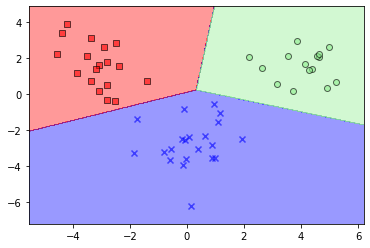

In [38]:
x_test_lda = lda.transform(x_test_std)
plot_regions(x_test_lda, y_test, classifier=lr)

# Kernel Principal Component Analysis

The dimensionality reduction algorithms above assume linear seperability of the input data. However, if we deal with nonlinear problems, LDA and PCA may not be the best choice. In this section, we will introduced Kernel PCA (KPCA) which uses the same idea as the Kernel Support Vector Machine. Using this, we will transform non-linearly seperable data to linearly separable data.

In [39]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons, make_circles

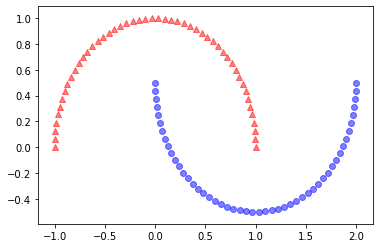

In [40]:
x,y = make_moons(n_samples=100, random_state=123)
plt.scatter(x[y==0,0], x[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(x[y==1,0], x[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)
plt.show()

In [41]:
kpca = KernelPCA(n_components=2, kernel = 'rbf', gamma = 15)
x_kpca = kpca.fit_transform(x)

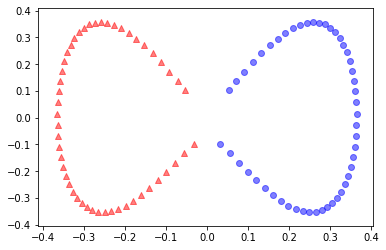

In [42]:
plt.scatter(x_kpca[y==0,0], x_kpca[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(x_kpca[y==1,0], x_kpca[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)

### Another example... 

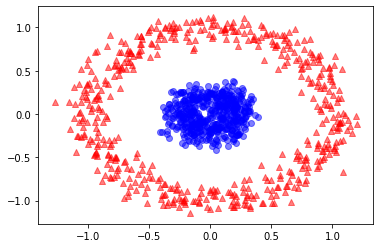

In [43]:
x,y = make_circles(n_samples=1000, random_state=123, noise = 0.1, factor = 0.2)
plt.scatter(x[y==0,0], x[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(x[y==1,0], x[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)
plt.show()

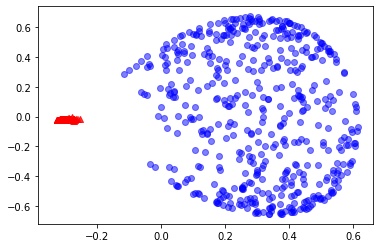

In [44]:
kpca = KernelPCA(n_components=2, kernel = 'rbf', gamma = 15)
x_kpca = kpca.fit_transform(x)

plt.scatter(x_kpca[y==0,0], x_kpca[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(x_kpca[y==1,0], x_kpca[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)

Compare with the PCA...

In [45]:
from sklearn.decomposition import PCA

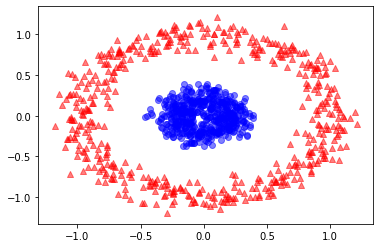

In [46]:
x,y = make_circles(n_samples=1000, random_state=123, noise = 0.1, factor = 0.2)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

plt.scatter(x_pca[y==0,0], x_pca[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(x_pca[y==1,0], x_pca[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)